In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
eps = {'x': 0.4, 'y': 0.4}
gl_bounds = {'x': [0, 1], 'y': [0, 1]} # global bounds
true_coords = {'x': 0.6, 'y': 0.4}

# lines stored as [p_start, p_end] = [[x_st, y_st], [x_end, y_end]]
x1, y1, x2, y2 = 0.2, 0.3, 0.6, 0.9
lines = np.array([[[0, y1], [x1, 1]], [[1, y2], [x2, 0]]])

In [ ]:
def intersect_with_square(line, gl_bounds):
    p_st, p_end = np.array(line)
    included_corners = []
    for x in gl_bounds['x']:
        for y in gl_bounds['y']:
            cross_pr = np.cross(p_end - p_st, np.array([x, y]) - p_st)
            if cross_pr > 0:
                included_corners.append([cross_pr, [x, y]])
    included_corners.sort(reverse=True)
    x_, y_ = [p_st[0], p_end[0]], [p_st[1], p_end[1]]
    for _, corner in included_corners:
        x_.append(corner[0])
        y_.append(corner[1])
    return x_, y_

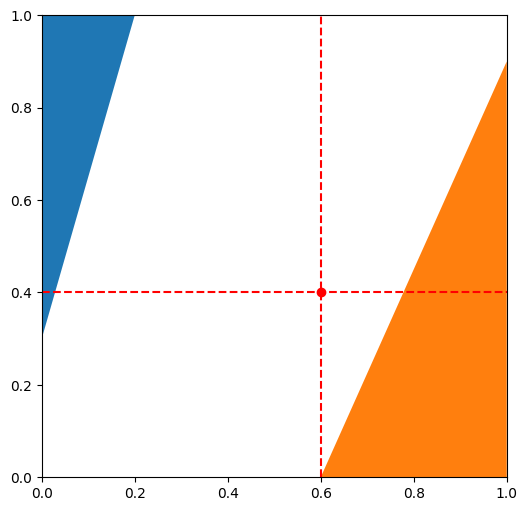

In [ ]:
# square 1 x 1
def draw(fig, ax, lines, true_coords, gl_bounds):
    for line in lines:
        x, y = intersect_with_square(line, gl_bounds)
        ax.fill(x, y)
    ax.plot(true_coords['x'], true_coords['y'], marker='o', color='red')
    ax.vlines(true_coords['x'], 0, 1, colors='red', linestyle='dashed')
    ax.hlines(true_coords['y'], 0, 1, colors='red', linestyle='dashed')

    ax.set(xlim=gl_bounds['x'], ylim=gl_bounds['y'])


fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 6))
draw(fig, ax, lines, true_coords, gl_bounds)